In [23]:
import json
from typing import List, Tuple

import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
from transformers import DistilBertTokenizer, DistilBertModel
import pandas as pd
import numpy as np

import seaborn as sns
import random

# Data

In [3]:
with open("../data/train.json") as json_file:
    data = json.load(json_file)

In [4]:
print(data[0]['data']['text'])

      IN THE HIGH COURT OF KARNATAKA,
          CIRCUIT BENCH AT GULBARGA

DATED THIS THE 22ND DAY OF FEBRUARY, 2013

      BEFORE

THE HON'BLE MR.JUSTICE ANAND BYRAREDDY

      CRIMINAL APPEAL NO.3532 OF 2012

BETWEEN:                                            R

Babu S/o Siddappa,                         .. APPELLANT
Age: 30 Years, Occ: Household,
R/o: Sunthan Village,
Taluk Chincholi,
District Gulbarga.

(By Shri Ishwar Raj S.Chowdapur, Advocate)

AND:

The State of Karnataka                     .. RESPONDENT
(Through Ratkal Police Station)
Represented by Additional State
Public Prosecutor, Circuit Bench,
Gulbarga.

(By Shri S.S.Aspalli, Government Pleader)

       This Criminal Appeal is filed under Section 374(2) of the
Code of Criminal Procedure, 1973 by the advocate for the
appellant praying to set aside the order of conviction and

sentence in S.C.No.232/2008 on the file of the II Additional
Sessions Judge, Gulbarga and acquit the appellant.

       This appeal coming on for h

In [5]:
data[0].keys()

dict_keys(['id', 'annotations', 'data', 'meta'])

In [6]:
# doc = data[0]['data']['text']
# used = doc[:doc.rindex("ACT:")]
# doc = doc[doc.rindex("ACT:"):]
# print(used)
# print("-----------------------------")
# print(doc)

In [7]:
# def extract_sentences(text, start_text):
#     pattern = re.compile(rf'\b{re.escape(start_text)}.*?[.!?](?=\s|$)', re.IGNORECASE | re.DOTALL)
#     matches = re.findall(pattern, text)
#     return matches

# # Example usage:
# # text_to_search = "This is a sample text. Starting sentence with given text. Another sentence with the given text. Not starting with it."

# start_text = "CITATION"
# result = extract_sentences(doc, start_text)

In [8]:
len(data[0]['annotations'])

1

In [9]:
data[0]['annotations'][0].keys()

dict_keys(['result'])

In [10]:
len(data[0]['annotations'][0]['result'])

91

# Tokenizing

In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# print(tokenizer)

### Extract info from dictionary

In [12]:
sent_id = []
sent_start = []
sent_end = []
train_sents = []
target = []
for entry in data:
    _ids, _start, _end, _text, _labels = [], [], [], [], []
    # print(entry)
    # print(entry['annotations'][0]['result'])
    # for x , y in [(data_point['text'], data_point['labels']) for data_point in entry['annotations'][0]['result']['value']]:
    for data_point in entry['annotations'][0]['result']:
        _ids.append(data_point['id'])
        _start.append(data_point['value']['start'])
        _end.append(data_point['value']['end'])
        _text.append(data_point['value']['text'])
        _labels.append(data_point['value']['labels'][0])
    
    sent_id.append(_ids)
    sent_start.append(_start)
    sent_end.append(_end)
    train_sents.append(_text)
    [target.append(label) for label in _labels]

In [13]:
unique_labels = set(target)

### Tokenize sentences and add CLS and SEP tokens

In [101]:
try:
    doc_lens = []
    for doc_index, doc in enumerate(train_sents):
        sent_lens = []
        for sent_index, sentence in enumerate(doc):
            train_sents[doc_index][sent_index] = [tokenizer.cls_token] + tokenizer.tokenize(sentence) + [tokenizer.sep_token]
            sent_lens.append(len(train_sents[doc_index][sent_index]))    
        doc_lens.append(sent_lens)
    
except TypeError:
    print("Sentences already tokenized. Check again")

In [102]:
print(f"Number of documents : {len(train_sents)}")

Number of documents : 30


In [110]:
df = pd.DataFrame()
df['lengths'] = doc_lens 
df['max_length'] = [np.max(i) for i in doc_lens]  
df['avg_length'] = [np.mean(i) for i in doc_lens]

In [111]:
df.head()

,lengths,max_length,avg_length
0,"[29, 19, 116, 40, 18, 30, 20, 55, 45, 33, 19, ...",311,42.416667
1,"[10, 29, 49, 10, 79, 26, 23, 29, 32, 50, 24, 2...",176,35.223022
2,"[16, 15, 10, 152, 40, 48, 51, 24, 51, 66, 18, ...",152,32.913333
3,"[22, 10, 195, 47, 11, 31, 44, 22, 11, 37, 6, 5...",195,37.851852
4,"[29, 18, 14, 6, 15, 24, 15, 18, 21, 8, 11, 11,...",152,26.418605


In [112]:
df.max_length.quantile(0.85)

215.54999999999995

In [114]:
df.avg_length.quantile(0.99)

57.62580645161291

329


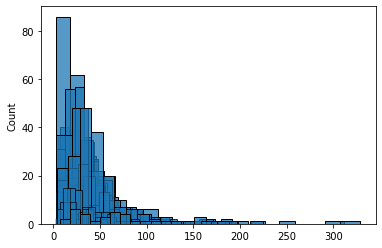

In [105]:
max_length = 0
for index, row in df.iterrows():
    sns.histplot(row['lengths'],bins=15)
    if row['max_length'] > max_length:
        max_length = row['max_length']
        
print(max_length)

### Padding the sentences with PAD token

In [34]:
# # MAX_LENGTH = 330
# # attention_matrix = np.zeros(train_sents)
# for doc_index, doc in enumerate(train_sents):
#     MAX_LENGTH = df.iloc[doc_index]['max_length'] + 1
#     for sent_index, sentence in enumerate(doc):
#         train_sents[doc_index][sent_index] = train_sents[doc_index][sent_index] + [tokenizer.pad_token for _ in range(MAX_LENGTH - len(train_sents[doc_index][sent_index]))]
#         # for token in train_sents[doc_index][sent_index]:
#         # attention_matrix[doc_index][sent_index] = [1 if token != tokenizer.pad_token else 0 for token in train_sents[doc_index][sent_index]]

### Creating attention matrix for each document

In [35]:
# ids = []
# segs = []
# for doc_index, doc in enumerate(train_sents):
#     globals()[f"attention_mask_{doc_index}"] = np.zeros_like(doc,dtype='int')
#     sent_id = []
#     sent_segs = []
#     for sent_index,sentence in enumerate(doc):
#         sent_id.append(tokenizer.convert_tokens_to_ids(sentence))
#         sent_segs.append([0 for _ in range(len(sentence))])
#         for i in range(len(sentence)):
#             if sentence[i] != tokenizer.pad_token:
#                 globals()[f'attention_mask_{doc_index}'][sent_index][i] = 1 
#     ids.append(sent_id)
#     segs.append(sent_segs)

In [36]:
# len(ids)
# # len(segs)

In [37]:
# for i in range(len(train_sents)):
#     print(f'Attention Mask for document {i+1} : {globals()[f"attention_mask_{i}"].shape}')

# Extracting sentence embeddings

In [38]:
# model = BertModel.from_pretrained("bert-base-uncased")

In [39]:
# for i in range(len(train_sents)):
#     globals()[f'ids_tensor_{i}'] = torch.LongTensor(ids[i]).unsqueeze(0)
#     globals()[f'attention_mask_{i}'] = torch.from_numpy(globals()[f'attention_mask_{i}']).unsqueeze(0)
#     globals()[f'seg_tokens_{i}'] = torch.LongTensor(segs[i]).unsqueeze(0)

In [40]:
# type(attention_mask_0)

In [41]:
# type(ids_tensor_0)

In [42]:
# type(seg_tokens_0)

In [43]:
# globals()[f'ids_tensor_{0}'][:,0,:]

In [109]:
# for doc_index, doc in enumerate(train_sents):
#     last_hidden_state = []
#     pooler_output = []
#     for sent_index in range(len(doc)):
#         # if doc_index == 0:
#             # print(sent_index)
#         output = model(globals()[f'ids_tensor_{doc_index}'][:,sent_index,:],
#                         attention_mask = globals()[f'attention_mask_{doc_index}'][:,sent_index,:],
#                         token_type_ids = globals()[f'seg_tokens_{doc_index}'][:,sent_index,:])
#         last_hidden_state.append(output[0])
#         pooler_output.append(output[1])
#     globals()[f'last_hidden_state_{doc_index}'], globals()[f'pooler_output_{doc_index}'] = last_hidden_state, pooler_output

: 

In [44]:
# model(ids_tensor_0[:,0,:],attention_mask_0[:,0,:],seg_tokens_0[:,0,:]).pooler_output.size()

In [45]:
# sentence_embeddings = []
# for i in range(15):
#     emb = model(ids_tensor_0[:,i,:],attention_mask_0[:,i,:],seg_tokens_0[:,i,:]).pooler_output
#     sentence_embeddings.append(emb.squeeze(0))

In [46]:
# sentence_embeddings[0]

 - Create function that given a sentence produces id, attention mask and seg
 - Create a function that uses those 3 as input and produces embeddings on the fly

# Tom's work

In [47]:
# from transformers import BertTokenizer, BertModel
# import torch

# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertModel.from_pretrained('bert-base-uncased')

# import json

# file_path = '../data/train.json'

# with open(file_path, 'r') as file:
#     data = json.load(file)
    
#     for key, value in data[0].items():
        
#         if key == 'annotations':
#             for element in value:
#                 for key2, value2 in element.items():
#                     for element2 in value2:
#                         for key3, value3 in element2.items():
#                             if isinstance(value3, dict):
#                                 for key4, value4 in value3.items():
#                                     if key4 == "text":
#                                         print(value4)
                                        
#                                     inputs = tokenizer(key4, return_tensors="pt", truncation=True, padding=True)
#                                     outputs = model(**inputs)

#                                     bert_embedding = outputs.last_hidden_state[:, 0, :]


#                                     bert_embedding_np = bert_embedding.detach().numpy()

                                    
#                                     print(bert_embedding_np.shape)

# Simple CNN implementation

## Label Encoding

In [15]:
from sklearn.preprocessing import LabelEncoder
def label_encode(target_variables : list) -> LabelEncoder:
    """
    Encode target variables using one-hot encoding.
    
    Args:
    - target_variables (list or array-like): List of target variable strings.
    
    Returns:
    - lb (object): class object used to tranform and inverse transform.
    """
    le = LabelEncoder()
    le = le.fit(target_variables)
    
    return le

In [16]:
unique_labels

{'ANALYSIS',
 'ARG_PETITIONER',
 'ARG_RESPONDENT',
 'FAC',
 'ISSUE',
 'NONE',
 'PREAMBLE',
 'PRE_NOT_RELIED',
 'PRE_RELIED',
 'RATIO',
 'RLC',
 'RPC',
 'STA'}

In [17]:
label_encoder = label_encode(list(unique_labels))

#### Example usage

In [18]:
label_encoder.transform(["ISSUE"])

array([4])

In [19]:
label_encoder.inverse_transform([2])

array(['ARG_RESPONDENT'], dtype='<U14')

# CNN

In [79]:
print(f"Number of documents for training : {len(data)}")

Number of documents for training : 247


In [80]:
doc1_train_data = data[0]['annotations'][0]['result']
type(doc1_train_data)

list

In [81]:
len(doc1_train_data)

91

In [40]:
def sent2tensors(sentence: str, MAX_LEN = None) -> dict:
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    # print(tokenizer.tokenize(sentence))
    if MAX_LEN is None:
        inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True)
    else:
        inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding='max_length',max_length = MAX_LEN)
    return inputs

def sent2wordemb(sentence: str, MAX_LEN = None) -> torch.TensorType:
    model = BertModel.from_pretrained('bert-base-uncased')
    
    inputs = sent2tensors(sentence,MAX_LEN)
    with torch.no_grad():
        emb = model(**inputs)
    
    return emb[0]

def sent2emb(sentence: str) -> torch.TensorType:
    model = BertModel.from_pretrained('bert-base-uncased')
    with torch.no_grad():
        inputs = sent2tensors(sentence)
        emb = model(**inputs).pooler_output
    
    return emb

In [41]:
sent2tensors("i have a cat")

{'input_ids': tensor([[ 101, 1045, 2031, 1037, 4937,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

In [42]:
word_emb = sent2wordemb('i have a cat')

In [43]:
word_emb.size()

torch.Size([1, 6, 768])

In [25]:
# class word_level_CNN(nn.Module):
#     def __init__(self, input_channels : int = 1, output_channels : int = 1, kernel_size : int = (5,1)):
#         super(word_level_CNN, self).__init__()
#         # Convolutional layer
#         self.conv1 = nn.Conv2d(in_channels = input_channels,
#                                out_channels = output_channels,
#                                kernel_size = kernel_size)
#         # ReLU activation
#         self.relu = nn.ReLU()
#         # Max pooling layer
#         self.max_pool = nn.MaxPool2d(kernel_size = (2,1))
        
#     def forward(self, x):
#         print(x.size())
#         x = x.view(x.size(0), x.size(1), -1)
#         x = self.conv1(x)
#         # print("After Convolution : ", x.size())
#         x = self.relu(x)
#         x = self.max_pool(x)
#         # print("After Max-Pooling : ", x.size())
#         return x

In [26]:
# class sent_level_CNN(nn.Module):
#     def __init__(self, input_channels : int = 3, output_classes : int = 1):
#         super(sent_level_CNN, self).__init__()
#         # Convolutional layer
#         self.conv1 = nn.Conv2d(in_channels = input_channels,
#                                out_channels = output_classes,
#                                kernel_size = (1,1))
#     def forward(self, x):
#         print(x.size())
#         # Forward pass through the layers
#         x = self.conv1(x)
#         # print("After Convolution : ", x.size())
        
#         return x

In [27]:
# def extract_word_embeddings(sentence,MAX_LEN = None):
#     # Load pre-trained DistilBERT model and tokenizer
#     model_name = 'distilbert-base-uncased'
#     model = DistilBertModel.from_pretrained(model_name)
#     tokenizer = DistilBertTokenizer.from_pretrained(model_name)
#     # print(tokenizer.tokenize(sentence))

#     # Tokenize the input sentence
#     tokens = tokenizer(sentence, return_tensors='pt', padding='max_length', truncation=True, max_length = MAX_LEN, add_special_tokens=True)

#     # Obtain the output embeddings from the model
#     with torch.no_grad():
#         outputs = model(**tokens)

#     # Extract the embeddings for each token
#     embeddings = outputs.last_hidden_state

#     return embeddings

In [87]:
doc1_train_data[0]

{'id': 'd7a902fe9c23417499a7ef782f9fbdeb',
 'type': 'labels',
 'to_name': 'text',
 'from_name': 'label',
 'value': {'start': 0,
  'end': 116,
  'text': '      IN THE HIGH COURT OF KARNATAKA,\n          CIRCUIT BENCH AT GULBARGA\n\nDATED THIS THE 22ND DAY OF FEBRUARY, 2013',
  'labels': ['PREAMBLE']}}

In [89]:
# train_dict = {}
max_sent_tok_len = 128

for index, entry in enumerate(doc1_train_data):
    print(index)
    if index == 2:
        break
    sent_triplet = []
    sent_tensor = torch.Tensor()
    if index == 0: # for start of document only pair of sentences taken
        sent_triplet.append(doc1_train_data[index]['value']['text'])
        sent_triplet.append(doc1_train_data[index]['value']['text'])
        sent_triplet.append(doc1_train_data[index+1]['value']['text'])
    elif index == len(doc1_train_data) - 1: # for end of document only pair of sentences taken
        sent_triplet.append(doc1_train_data[index-1]['value']['text'])
        sent_triplet.append(doc1_train_data[index]['value']['text'])
        sent_triplet.append(doc1_train_data[index]['value']['text'])
    else:
        sent_triplet.append(doc1_train_data[index-1]['value']['text'])
        sent_triplet.append(doc1_train_data[index]['value']['text'])
        sent_triplet.append(doc1_train_data[index+1]['value']['text'])
    
    for sent in sent_triplet:
        sent_emb = sent2wordemb(sent,MAX_LEN = max_sent_tok_len)
        sent_tensor = torch.cat((sent_tensor,sent_emb),dim=0) # creating triplet of word level CNN outputs
        
    print(sent_tensor.size())
    # final_emb_tensor = sent_cnn.forward(sent_tensor).squeeze(0) # sentence level CNN
    target_encoded = torch.from_numpy(label_encoder.transform(entry['value']['labels'])).float()
    # print(f"Input tensor :  {final_emb_tensor.size()}")
    # print(f"Target :  {target_encoded.size()}")
    # # train_dict[f"{index}"] = {"input" : final_emb_tensor, "target" : entry['value']['labels']}

0
torch.Size([3, 128, 768])
1
torch.Size([3, 128, 768])
2


In [90]:
sent_tensor.size()

torch.Size([3, 128, 768])

In [31]:
# individual_tens = sent_tensor.unbind(0)

In [32]:
# for tens in individual_tens:
#     print(tens.size())

In [33]:
# final_emb_tensor.size()

In [34]:
# target_encoded.size()

In [35]:
# label_encoder.inverse_transform(target_encoded)

# BiLSTM

In [123]:
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BiLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Bidirectional LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)

        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size * 2, 128)  # *2 for bidirectional
        self.fc2 = nn.Linear(128, output_size)
        
        # # Activation function
        self.relu = nn.ReLU()

    def forward(self, x, hidden, cell):
        # Initialize hidden state and cell state
        # h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size)  # *2 for bidirectional
        # c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size)

        # Forward pass through LSTM layer
        out, (hidden,cell) = self.lstm(x.unsqueeze(0), (hidden, cell))

        # Take the output from the last time step
        out = out[:, -1, :]

        # Fully connected layers
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)

        return out, (hidden,cell)
    
    def init_hidden(self, batch_size=1):
        """
        Initialize the hidden and cell states of the LSTM model.

        Args:
            batch_size (int, optional): Batch size for initialization. Defaults to 1.

        Returns:
            tuple: Tuple containing the initialized hidden and cell states.
        """
        hidden = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size)
        cell = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size)
        return hidden, cell

In [124]:
bilstm = BiLSTM(input_size=768,hidden_size=256,num_layers=2,output_size=13)

In [125]:
hidden, cell = bilstm.init_hidden()
bilstm.zero_grad()
loss = 0
criterion = nn.CrossEntropyLoss()

In [126]:
out, (hidden,cell) = bilstm.forward(final_emb_tensor,hidden,cell)

In [127]:
out.size()

torch.Size([1, 13])

In [128]:
target_encoded.dtype

torch.float32

In [129]:
target_encoded.size()

torch.Size([1, 13])

In [130]:
criterion(out,target_encoded)

tensor(2.5396, grad_fn=<DivBackward1>)

In [134]:
word_cnn.parameters

<bound method Module.parameters of word_level_CNN(
  (conv1): Conv2d(1, 1, kernel_size=(5, 1), stride=(1, 1))
  (relu): ReLU()
  (max_pool): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
)>

In [135]:
sent_cnn.parameters

<bound method Module.parameters of sent_level_CNN(
  (conv1): Conv2d(3, 1, kernel_size=(1, 1), stride=(1, 1))
)>

In [132]:
bilstm.parameters

<bound method Module.parameters of BiLSTM(
  (lstm): LSTM(768, 256, num_layers=2, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=13, bias=True)
  (relu): ReLU()
)>

# CNN BiLSTM

In [105]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

class CNN_BiLSTM(nn.Module):
    def __init__(self,
                word_input_channels:int = 1,
                word_output_channels:int = 1,
                word_kernel_size:Tuple[int,int] = (5,1),
                sent_input_channels:int = 3,
                sent_output_channels:int = 1,
                input_size:int = 768,
                hidden_size:int = 256,
                num_layers:int = 2,
                output_size:int = 13,
                ) -> None:
        super(CNN_BiLSTM,self).__init__()
        # Word Level CNN
        self.word_conv = nn.Sequential(nn.Conv2d(in_channels = word_input_channels,
                                                out_channels = word_output_channels,
                                                kernel_size = word_kernel_size,
                                                padding='same'),
                                       nn.ReLU(),
                                       nn.MaxPool2d(kernel_size = (2,1)),
                                       nn.Dropout(p=0.2)
        )
        # Sentence Level    
        self.sent_conv = nn.Conv2d(in_channels = sent_input_channels,
                                   out_channels = sent_output_channels,
                                   kernel_size = (1,1))
        # BiLSTM
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.bilstm = nn.LSTM(input_size = input_size,
                              hidden_size = hidden_size,
                              num_layers = num_layers,
                              batch_first=True,bidirectional=True)
        
        self.dense = nn.Sequential(nn.Linear(in_features= hidden_size*2, out_features= 128),
                                   nn.ReLU(),
                                   nn.Linear(in_features= 128, out_features= output_size),
                                   nn.Softmax(dim=0),
        )
        
        self.apply(init_weights) #pytorch weight initialization is poor by default
        
    def forward(self, x):
        sent_ten = torch.Tensor()
        # Passing through the word level CNN
        # Takes sentence word-level embeddings of 3 sentences
        # passes each sentence through the word level CNN 
        # concats the output to form a 3,38,768 tensor
        ind_x = x.unbind(0)
        for int_x in ind_x:
            int_x = int_x.unsqueeze(0)
            int_x = self.word_conv(int_x)
            sent_ten = torch.cat((sent_ten,int_x),dim=0)
            
        # 3,38,768 tensor passes through sentence level CNN
        # output is a 1,38,768 tensor
        x = self.sent_conv(sent_ten)
        
        # Forward pass through LSTM layer
        for i in range(x.size(-2)):
            if i == 0:
                out, (hidden,cell) = self.bilstm(x[:,i,:].unsqueeze(1))
            else:
                out, (hidden,cell) = self.bilstm(x[:,i,:].unsqueeze(1),(hidden,cell))
        
        # out, (hidden,cell) = self.bilstm(x, (hidden, cell))

        # Take the output from the last time step
        out = out.view(-1)

        # Fully connected layers
        out = self.dense(out)
        return out
        # return out, (hidden,cell)

    # def init_hidden(self, batch_size=1):
    #     """
    #     Initialize the hidden and cell states of the LSTM model.

    #     Args:
    #         batch_size (int, optional): Batch size for initialization. Defaults to 1.

    #     Returns:
    #         tuple: Tuple containing the initialized hidden and cell states.
    #     """
    #     hidden = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size)
    #     cell = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size)
    #     return hidden, cell

In [106]:
cnn_lstm = CNN_BiLSTM()
# hidden,cell = cnn_lstm.init_hidden()

In [107]:
output = cnn_lstm.forward(sent_tensor)

In [118]:
output

tensor([0.0826, 0.0677, 0.0723, 0.0717, 0.0745, 0.0727, 0.0889, 0.0780, 0.0799,
        0.0746, 0.0729, 0.0824, 0.0819], grad_fn=<SoftmaxBackward0>)

In [111]:
criterion = nn.CrossEntropyLoss()

In [114]:
loss = criterion(output,target_encoded.squeeze())

In [115]:
loss.backward()

In [116]:
optimizer = torch.optim.Adam(cnn_lstm.parameters(),lr=0.005)

In [117]:
optimizer.step()

In [119]:
output = cnn_lstm.forward(sent_tensor)
output

tensor([2.7329e-05, 2.7407e-06, 1.4756e-05, 2.9473e-05, 3.5469e-06, 1.2904e-05,
        9.9941e-01, 1.5726e-05, 3.5430e-05, 4.9757e-07, 3.6099e-05, 3.9808e-04,
        1.0537e-05], grad_fn=<SoftmaxBackward0>)

# Simple FF Neural Network

In [50]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

class FFNN(nn.Module):
    def __init__(self, input_size:int = 768, output_size:int = 13) -> None:
        super().__init__()
        
        self.dense = nn.Sequential(nn.Linear(in_features = input_size,out_features=384),
                                   nn.Dropout(p=0.2,inplace=True),
                                   nn.ReLU(),
                                   nn.Linear(in_features=384, out_features=96),
                                   nn.ReLU(),
                                   nn.Linear(in_features=96, out_features=output_size),
                                   nn.Softmax(dim=0),
                                   )
        
        self.apply(init_weights)
        
    def forward(self, x : torch.TensorType):
        output = self.dense(x)
        
        return output

In [56]:
model = FFNN()
model_opt = torch.optim.RMSprop(model.parameters(), lr = 0.01)
loss_function = nn.CrossEntropyLoss()

In [57]:
# all_losses = []

# for doc_index, doc in enumerate(data):
#     if doc_index > 3:
#         break
#     train_document = doc['annotations'][0]['result']
#     for entry_index, entry in enumerate(train_document):
#         sentence = entry['value']['text']
#         label = entry['value']['labels']
        
#         sent_emb = sent2emb(sentence).squeeze(0)
#         target_encoded = torch.from_numpy(label_encoder.transform(label)).float().squeeze(0)
#         # print(f"{sent_emb.size()}   {target_encoded.size()}")
#         model_optimizer.zero_grad()
        
#         output = simple_nn(sent_emb)
#         # print(f"{output.size()}")
        
#         out = torch.zeros_like(output)
#         out[torch.argmax(output).item()] = 1.
#         prediction = label_encoder.inverse_transform(out.unsqueeze(0))[0]
#         target_str = label_encoder.inverse_transform(target_encoded.unsqueeze(0))[0]
#         print(f"Prediction: {prediction}, Target: {target_str}")
        
#         loss = loss_function(output,target_encoded)
#         loss.backward()
#         model_optimizer.step()
        
        
#         all_losses.append(loss)
#         print(f"Loss : {loss}")

In [61]:
import pickle 
import os

def load_encoded(directory, filename):
    filepath = os.path.join(directory, filename)
    
    with open(filepath, 'rb') as f:
        target_encoded = pickle.load(f)
    
    return target_encoded

def train(model : object, loss_fn : object,
          inp : torch.TensorType, target : torch.TensorType) -> float:
    """
    Train the decoder model for a single step using the given input and target sequences.

    Args:
        decoder (object): The decoder model to be trained.
        decoder_optimizer (object): The optimizer for updating the decoder's parameters.
        inp (torch.TensorType): The input sequence tensor.
        target (torch.TensorType): The target sequence tensor.

    Returns:
        float: The normalized loss for the current training step, averaged over the sequence length.
    """
    output = model(inp)
    # print(output.size())
    print(f"output size: {output.size()}, target_size: {target.size()} ")
    loss = loss_fn(output, target)
    
    out = torch.argmax(output).item()
    prediction = label_encoder.inverse_transform([out])[0]
    target_str = label_encoder.inverse_transform(target)[0]
    print(f"Prediction: {prediction}, Target: {target_str}, Loss: {loss.item()}")
    
    return loss

In [62]:
all_losses = []
for epoch in range(20):
    losses = []
    for _ in range(10):
        doc_num = random.randint(0,3)
        file_num = random.randint(0,len(data[doc_num]['annotations'][0]['result'])-1)
        sentence = data[doc_num]['annotations'][0]['result'][file_num]['value']['text']
        label = data[doc_num]['annotations'][0]['result'][file_num]['value']['labels']
        
        sent_emb = sent2emb(sentence)
        target_encoded = torch.from_numpy(label_encoder.transform(label)).long()
        losses.append(train(model,loss_function,sent_emb,target_encoded));
    avg_loss = torch.stack(losses).mean()
    avg_loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
    model_opt.step()
    model_opt.zero_grad()
    print(f"epoch: {epoch}, loss: {avg_loss}")
    all_losses.append(avg_loss.item())

output size: torch.Size([1, 13]), target_size: torch.Size([1]) 
Prediction: ANALYSIS, Target: ANALYSIS, Loss: 2.5649492740631104
output size: torch.Size([1, 13]), target_size: torch.Size([1]) 
Prediction: ANALYSIS, Target: ARG_RESPONDENT, Loss: 2.5649492740631104
output size: torch.Size([1, 13]), target_size: torch.Size([1]) 
Prediction: ANALYSIS, Target: RATIO, Loss: 2.5649492740631104
output size: torch.Size([1, 13]), target_size: torch.Size([1]) 
Prediction: ANALYSIS, Target: FAC, Loss: 2.5649492740631104
output size: torch.Size([1, 13]), target_size: torch.Size([1]) 
Prediction: ANALYSIS, Target: PRE_RELIED, Loss: 2.5649492740631104


KeyboardInterrupt: 

In [37]:
data[3]['annotations'][0]['result'][102]['value']['text']

'\nThe next decision is Gunda Subbayya v. Commissioner of Income-tax, Madras (1).'